# Test the ability of deepwalk to make predictions on semmeddb

Fold 0 only.

In [1]:
import pandas as pd
import numpy as np
import scipy

from sklearn.linear_model import LogisticRegression

from glob import glob
import seaborn as sns
from collections import defaultdict

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, precision_recall_curve

from itertools import product
from tqdm import tqdm

import random

In [2]:
%matplotlib inline

In [3]:
np.random.seed(20171115)

---

## Read semmeddb embedding

deepwalk parameters: 50 walks, 128 vecsize, 10 window size.

In [4]:
vecsize = 128

features = (pd
    .read_csv(
        "data/embeddings/sem50walk128vec10window.txt",
        sep=' ', skiprows=1,
        names=["uid"] + ["f{}".format(i) for i in range(vecsize)]
    )
)

In [5]:
features.head()

,uid,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127
0,11728,-0.364880,3.792458,-1.397374,0.759112,2.917878,-0.176155,-0.564531,0.842563,-0.224761,...,-4.287377,2.291287,1.062728,-1.022062,1.158340,1.375489,0.707240,-0.798140,0.265549,1.008619
1,2049,-2.405818,-3.281208,5.442310,1.949694,2.385109,-0.819011,-0.049137,-0.012040,-2.015012,...,-5.956447,2.372664,-1.301351,-0.197150,-0.536069,-3.845875,1.893585,2.490709,-3.045699,-2.791694
2,8081,0.658723,0.207870,5.323104,-1.736953,5.051743,-1.999842,-3.380626,0.289445,2.042453,...,0.520123,-0.190908,0.161119,0.818972,-1.207367,0.406293,-0.056115,1.821121,1.328484,-4.362211
3,4369,-1.625476,7.181020,-3.710097,-3.370679,2.942568,-2.319238,2.756862,-0.547414,2.251278,...,-1.954914,2.358400,2.579734,-1.074741,0.438799,0.064437,0.036294,-1.126031,2.002540,0.159338
4,43199,0.880009,4.827002,2.897967,0.444787,-2.483543,1.696095,-6.284511,1.747533,1.588262,...,-3.107903,-0.838388,2.420102,-2.941679,5.887329,0.134784,1.972876,-1.104905,2.946468,2.954355


In [6]:
features.shape

(210389, 129)

## Read training data

In [7]:
traind = pd.read_csv("data/training/clean_train0.tsv", sep='\t')

In [8]:
traind.head()

,chemical_id,disease_id,etype,chemical_uid,disease_uid
0,C0000473,C0000810,0,58,123
1,C0000477,C0000810,0,59,123
2,C0000618,C0000810,0,80,123
3,C0000948,C0000810,0,164,123
4,C0000956,C0000810,0,167,123


In [9]:
traind.shape

(1094871, 5)

## Subsample training data

In [10]:
trainpos = traind.query("etype == 1")
K = 3

train = (trainpos
    .append(
        (traind
            .query("etype == 0")
            .sample(len(trainpos) * K)
        )
    )
    .reset_index(drop=True)
)

## Add features

In [11]:
def add_features(df, features):
    return (df
        .merge(
            features, how="inner", left_on="chemical_uid", right_on="uid"
        )
        .drop("uid", axis=1)
        .merge(
            features, how="inner", left_on="disease_uid", right_on="uid"
        )
        .drop("uid", axis=1)
    )

def convolv_features(df, features, vecsize):
    reg = add_features(df, features)
    
    # do multiply and get rid of old features
    for i in range(vecsize):
        reg["conv{}".format(i)] = reg["f{}_x".format(i)] * reg["f{}_y".format(i)]

    reg = (reg
        .drop(
            ["f{}_x".format(i) for i in range(vecsize)], axis=1
        )
        .drop(
            ["f{}_y".format(i) for i in range(vecsize)], axis=1
        )
    )
        
    return reg

In [12]:
tmp = convolv_features(train, features, vecsize)

## Train classifier

In [13]:
feat_cols = ["conv{}".format(i) for i in range(vecsize)]

model = LogisticRegression(C=1e9)
model.fit(tmp[feat_cols], tmp["etype"])

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## Predict on holdout data

In [14]:
holdoutd = pd.read_csv("data/holdout/clean_holdout0.tsv", sep='\t')

In [15]:
test = convolv_features(holdoutd.drop("etype", axis=1), features, vecsize)

featcols = ["conv{}".format(i) for i in range(vecsize)]
ans = test.assign(predval = lambda df: model.predict_proba(df[featcols])[:, 1])

results = (ans
    [["chemical_id", "disease_id", "predval"]]
    .merge(
        holdoutd[["chemical_id", "disease_id", "etype"]],
        how="inner", on=["chemical_id", "disease_id"]
    )
)

In [16]:
results = results.rename(columns={"etype": "category"})

In [17]:
results.head()

,chemical_id,disease_id,predval,category
0,C0000473,C0001144,0.280261,0
1,C0000545,C0001144,0.460353,0
2,C0000618,C0001144,0.158595,0
3,C0000956,C0001144,0.013283,0
4,C0000970,C0001144,0.065635,0


---

## Draw curves

In [18]:
def plot_roc(res_df, metrics, name_map, title="ROC"):
    auroc_results = defaultdict(dict)

    for metric in metrics:
        tmp = res_df[["category", metric]].sort_values(metric)
        fpr, tpr, thresh = roc_curve(tmp["category"], tmp[metric])

        auroc_results[metric]['fpr'] = fpr
        auroc_results[metric]['tpr'] = tpr
        auroc_results[metric]['thresh'] = thresh
        auroc_results[metric]['auc'] = auc(fpr, tpr)

    lw = 3
    x = [i for i in np.arange(0.0,1.01,.01)]
    plt.plot(x,x, 'k--', lw=2)
    for metric in metrics:
        plt.plot(auroc_results[metric]['fpr'], auroc_results[metric]['tpr'], lw=lw,
                 label='{0} (area = {1:0.2f})'
                     .format(name_map[metric], auroc_results[metric]['auc']))
    fig = plt.gcf()
    fig.set_size_inches(8, 7)
    fig.set_tight_layout(False)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel('FPR', size=20)
    plt.ylabel('TPR', size=20)
    plt.title(title, size=24)
    plt.legend(loc="lower right", frameon=True, shadow=True, prop={'size':16});

In [19]:
def plot_pr(res_df, metrics, name_map, title="ROC"):
    auroc_results = defaultdict(dict)

    for metric in metrics:
        tmp = res_df[["category", metric]]
        precision, recall, thresh = precision_recall_curve(tmp["category"], tmp[metric])

        auroc_results[metric]['precision'] = precision
        auroc_results[metric]['recall'] = recall
        auroc_results[metric]['thresh'] = thresh
        auroc_results[metric]['auc'] = auc(recall, precision)

    lw = 3
    x = [i for i in np.arange(0.0,1.01,.01)]
    for metric in metrics:
        plt.plot(auroc_results[metric]['recall'], auroc_results[metric]['precision'], lw=lw,
                 label='{0} (area = {1:0.2f})'
                     .format(name_map[metric], auroc_results[metric]['auc']))
    fig = plt.gcf()
    fig.set_size_inches(8, 7)
    fig.set_tight_layout(False)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel('Recall', size=20)
    plt.ylabel('Precision', size=20)
    plt.title(title, size=24)
    plt.legend(loc="upper right", frameon=True, shadow=True, prop={'size':16});

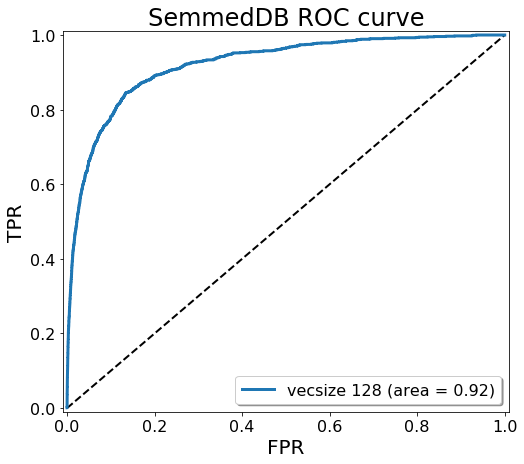

In [20]:
plot_roc(
    results,
    ["predval"],
    {"predval": "vecsize 128"},
    title="SemmedDB ROC curve"
)

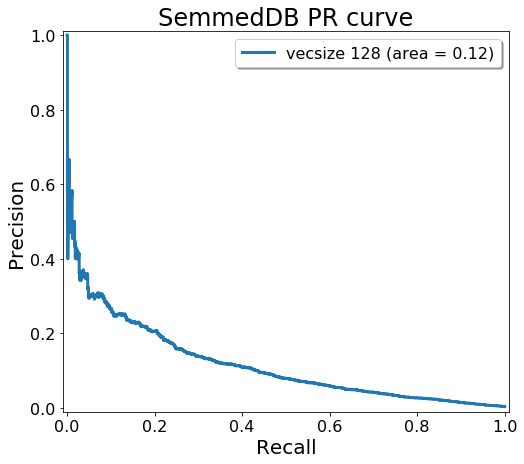

In [21]:
plot_pr(
    results,
    ["predval"],
    {"predval": "vecsize 128"},
    title="SemmedDB PR curve"
)

---

## Create full predictions on all chemical-disease pairs in semmeddb

In [22]:
nodemap = pd.read_csv("data/node_map.tsv", sep='\t')

In [23]:
nodemap.head()

,node_uid,node_id,name,ntype
0,0,C0000039,"1,2-Dipalmitoylphosphatidylcholine",Chemicals & Drugs
1,1,C0000052,"1,4-alpha-Glucan Branching Enzyme",Chemicals & Drugs
2,2,C0000084,1-Carboxyglutamic Acid,Chemicals & Drugs
3,3,C0000096,1-Methyl-3-isobutylxanthine,Chemicals & Drugs
4,4,C0000097,"1-Methyl-4-phenyl-1,2,3,6-tetrahydropyridine",Chemicals & Drugs


In [24]:
nodemap.shape

(214590, 4)

In [25]:
nodemap["ntype"].value_counts()

Chemicals & Drugs              84614
Living Beings                  48191
Disorders                      37284
Genes & Molecular Sequences    20539
Anatomy                        15100
Physiology                      7727
Phenomena                       1135
Name: ntype, dtype: int64

## Generate all chemical/disease pairs in semmeddb

3 billion pairs is too large to store at the moment, so we will do a sampling instead

some of the nodes in the original nodemap don't exist in the generated feature matrix, i think because they are unconnected nodes which don't go anywhere in the adjlist (thus are left out of walking)

need to verify this later

for now just amke sure that all nodes are from the existing set to avoid key errors



In [26]:
def get_simple_features(fname):
    """Get a dictionary of embeddings for all nodes.
    Faster than iterrowing the feature dataframe by 4x
    """

    res = dict()
    with open(fname, "r") as fin:
        nodes = int(fin.readline().split(" ")[0])

        for line in tqdm(fin, total=len(features)):
            vals = line.rstrip("\n").split(" ")

            uid = int(vals[0])
            res[uid] = list(map(float, vals[1:]))
            
    return res

In [27]:
sfeats = get_simple_features("data/embeddings/sem50walk128vec10window.txt")

100%|██████████| 210389/210389 [00:08<00:00, 23841.26it/s]


In [28]:
def convolv(chemuid, diseuid):
    """Get convolved features."""
    return [
        sfeats[chemuid][i] * sfeats[diseuid][i]
        for i in range(vecsize)
    ]

### Filter to nodes which have embeddings

In [29]:
tmp = set(features["uid"])

goodnodes = nodemap.query("node_uid in @tmp")

In [30]:
goodnodes.shape

(210389, 4)

In [31]:
goodnodes.head()

,node_uid,node_id,name,ntype
0,0,C0000039,"1,2-Dipalmitoylphosphatidylcholine",Chemicals & Drugs
1,1,C0000052,"1,4-alpha-Glucan Branching Enzyme",Chemicals & Drugs
2,2,C0000084,1-Carboxyglutamic Acid,Chemicals & Drugs
3,3,C0000096,1-Methyl-3-isobutylxanthine,Chemicals & Drugs
4,4,C0000097,"1-Methyl-4-phenyl-1,2,3,6-tetrahydropyridine",Chemicals & Drugs


In [32]:
goodnodes["ntype"].value_counts()

Chemicals & Drugs              80991
Living Beings                  48191
Disorders                      36706
Genes & Molecular Sequences    20539
Anatomy                        15100
Physiology                      7727
Phenomena                       1135
Name: ntype, dtype: int64

In [33]:
allchems = goodnodes.query("ntype == 'Chemicals & Drugs'")

In [34]:
alldises = goodnodes.query("ntype == 'Disorders'")

## Generate pairs

In [35]:
random.seed(345123461)

tchem = set(allchems["node_uid"])
tdise = set(alldises["node_uid"])

res = list()

ntotal = 200000

for i in tqdm(range(ntotal)):
    chemuid = random.sample(tchem, 1)[0]
    diseuid = random.sample(tdise, 1)[0]
    
    # convolved features for this chem dise pair
    cfeats = convolv(chemuid, diseuid)
    
    # reshape the features for use in prediction
    cfeats = np.array(cfeats).reshape(1, -1)
    
    # use the trained model to make a prediction
    pscore = model.predict_proba(cfeats)[0][1]
    
    res.append((chemuid, diseuid, pscore))
    
res = pd.DataFrame(res, columns=["chem_uid", "dise_uid", "pscore"])

100%|██████████| 200000/200000 [07:48<00:00, 427.11it/s]


---

### Score distribution

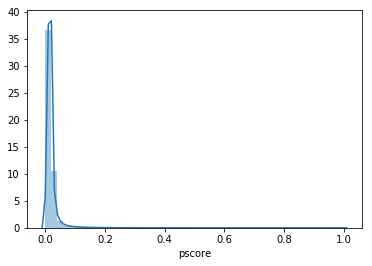

In [36]:
sns.distplot(res["pscore"])

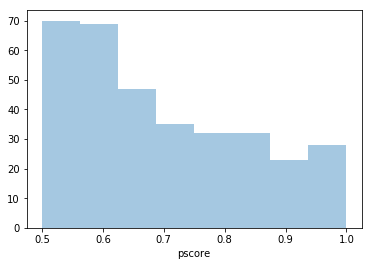

In [37]:
sns.distplot(res.query("pscore > 0.5")["pscore"], kde=False)

In [38]:
final = (res
    .merge(
        nodemap[["node_uid", "node_id", "name"]],
        how="inner", left_on="chem_uid", right_on="node_uid"
    )
    .merge(
        nodemap[["node_uid", "node_id", "name"]],
        how="inner", left_on="dise_uid", right_on="node_uid"
    )
    .drop(["node_uid_x", "node_uid_y"], axis=1)
    .rename(columns={
        "node_id_x": "chem_id",
        "name_x": "chem_name",
        "node_id_y": "dise_id",
        "name_y": "dise_name"
    })
    .sort_values(["pscore", "chem_uid", "dise_uid"], ascending=False)
    .reset_index(drop=True)
)

In [39]:
final.head()

,chem_uid,dise_uid,pscore,chem_id,chem_name,dise_id,dise_name
0,154665,93741,0.999879,C1098293,Ally,C0555047,Married
1,10999,60331,0.999375,C0032583,Polyproteins,C0275518,Acute infectious disease
2,61507,60877,0.996917,C0281606,recombinant viral vaccine,C0277525,Infectious gastroenteritis
3,10712,177075,0.994459,C0031881,Picloram,C1321554,Bacterial shell rot
4,13808,13002,0.992954,C0040577,Trace Elements,C0038340,Sting Injury


In [40]:
final.shape

(200000, 7)

In [41]:
final.to_csv("rand_pairs_results_test.tsv", sep='\t', index=False)

## Check overlap of top results with true pairs in training and holdout datasets

In [42]:
t = res.query("pscore > 0.5")
ppairs = set(zip(t["chem_uid"], t["dise_uid"]))

In [43]:
len(ppairs)

336

In [44]:
holdoutd.head()

,chemical_id,disease_id,etype,chemical_uid,disease_uid
0,C0000473,C0001144,0,58,256
1,C0000545,C0001144,0,71,256
2,C0000618,C0001144,0,80,256
3,C0000956,C0001144,0,167,256
4,C0000970,C0001144,0,175,256


In [45]:
a = traind.query("etype == 1")
b = holdoutd.query("etype == 1")
all_true = (
    set(zip(a["chemical_uid"], a["disease_uid"]))
    | set(zip(b["chemical_uid"], b["disease_uid"]))
)

In [46]:
len(all_true)

6329

In [47]:
len(ppairs & all_true)

0

seems like there's no overlap, which is good